In [37]:
import torch
import torchvision
import matplotlib.pyplot as plt
from timeit import default_timer
from torch import nn
from torchvision import transforms
from pathlib import Path

In [ ]:
try:
  from torchinfo import summary
except:
  print(f"summary not found.... installing")
  !pip install -q torchinfo
  from torchinfo import summary
  print(f"Summary has been sucessfully imported from torchinfo")

try:
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves
except:
  print(f"going_modular, helper_function not found..... Installing.....")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves
  print(f"sucessfully imported helper_funtion, going_modular")

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
data_path =  download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                           destination="pizza_steak_sushi_20_percent")
data_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [ ]:
train_dir = data_path/"train"
test_dir = data_path/"test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

### Creating a model using Effnetb2

In [ ]:
import urllib.request
import os

weights_url = "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth"
weights_path = "/root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth"

if not os.path.exists(weights_path):
    print("Downloading model weights...")
    urllib.request.urlretrieve(weights_url, weights_path)
else:
    print("Model weights file already exists.")


In [41]:
def Effnetb2_ModelV0(num_classes:int=3,
                     seed:int=25):

  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)


  for param in model.parameters():
    param.requires_grad = False


  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes)
  )

  return model, transforms

effnetb2, transforms = Effnetb2_ModelV0(num_classes=3,
                                        seed=25)

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=transforms,
                                                                               batch_size=16)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr = 0.00001)

results = engine.train(model=effnetb2,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1282 | train_acc: 0.2953 | test_loss: 1.1204 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.1228 | train_acc: 0.2931 | test_loss: 1.1042 | test_acc: 0.3896
Epoch: 3 | train_loss: 1.1056 | train_acc: 0.3405 | test_loss: 1.0968 | test_acc: 0.4125
Epoch: 4 | train_loss: 1.1110 | train_acc: 0.2909 | test_loss: 1.0936 | test_acc: 0.4062
Epoch: 5 | train_loss: 1.1096 | train_acc: 0.3405 | test_loss: 1.0872 | test_acc: 0.4313
Epoch: 6 | train_loss: 1.0922 | train_acc: 0.3621 | test_loss: 1.0754 | test_acc: 0.4646
Epoch: 7 | train_loss: 1.0960 | train_acc: 0.3470 | test_loss: 1.0731 | test_acc: 0.4500
Epoch: 8 | train_loss: 1.0864 | train_acc: 0.3966 | test_loss: 1.0706 | test_acc: 0.4750
Epoch: 9 | train_loss: 1.0773 | train_acc: 0.3966 | test_loss: 1.0614 | test_acc: 0.5000
Epoch: 10 | train_loss: 1.0542 | train_acc: 0.4806 | test_loss: 1.0576 | test_acc: 0.5000


In [42]:
ModelV0, ModelV0_transform = Effnetb2_ModelV0()

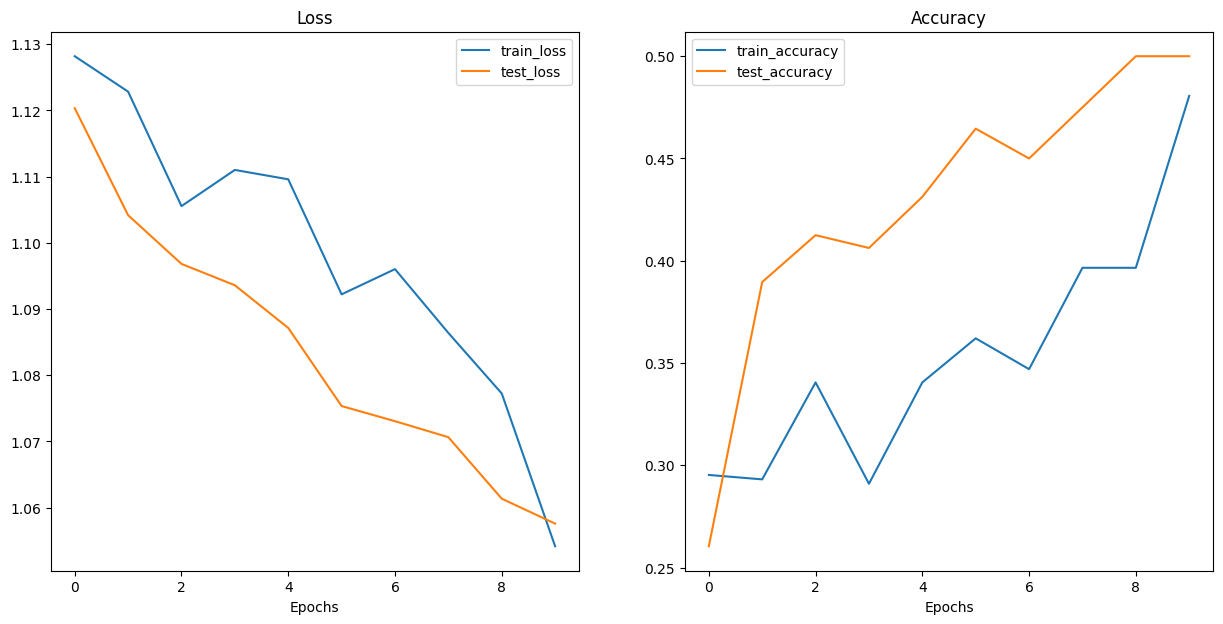

In [43]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

In [35]:
# Save model
from going_modular.going_modular import utils

utils.save_model(model=ModelV0,
                 target_dir="models",
                 model_name="ModelV0.pth")

[INFO] Saving model to: models/ModelV0.pth


In [39]:
# Getting the model size and conver it to MB
model_size= Path("models/ModelV0.pth").stat().st_size/ (1024 * 1024)

# Getting the total number of parameters
total_parameters = sum(torch.numel(params) for params in effnetb2.parameters())

# Creating a dictionary with Effnetb2 statistics
model_stats = {"test loss": results["test_loss"][-1],
               "test accuracy": results["test_acc"][-1],
               "number of parameters": total_parameters,
               "model size": model_size}

model_stats

{'test loss': 0.26915180683135986,
 'test accuracy': 0.975,
 'number of parameters': 7705221,
 'model size': 29.81792640686035}